# Returning phase advances from IOTA 8.2 lattice with space charge

This notebook will look to implement a step-end action which calculates the phase advance (or returns particle coordinates) from 2 different positions in the lattice. This will require that I can appropriately transform into normalized coordinates at any position in the lattice! 

**Questions**
- Where do I output particle data? At the start or the end of the slice?
- Can I transform into normalized coordinates everywhere in the lattice?
- How can I get single turn fidelity on the tune measurement? I should be able to just plot both points and show that they are pi out of phase (e.g. a line through the center of the normal form goes through each point).

**On steps and slices**
- Each step in the stepper applies operations which traverse slices. That is, each slice is used for metering out the split-operator method used by Synergia. Thus, each step has operators (1st half + collective + 2nd half). The non-collective operators have slices, and those slices have left/right spatial identifiers. Thus it should be possible to get the appropriate 's' value by accumulating the 'right' positions...

- The step end action should take place at the end of a step.

- *Deciding on where to grab particles* - Conveniently, markers have been identified in the MADX lattice file to identify the start and end of the nonlinear element.  `nlr2` marks the end, while `nlr1` marks the beginning. We will just look at element names to determine if we've found the correct slice.


**Parameters for SC Match**
- 20 mm-mrad emittance - KV distribution
- Nparticles = 1.25 * 10^7/cm == 4.75 mA without bunching = Tune depression -0.1


## Imports

In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a 'Nathan Cook'

Nathan Cook 23/02/2016 

CPython 2.7.10
IPython 4.0.2


In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [4]:
from base_diagnostics import utils
from base_diagnostics import StandardBeam6D
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from elliptic import EllipticBeam6D
from semiGaussian import SemiGaussian6D
#from standard import StandardBeam6D
import synergia
import synergia_workflow

## Load options and lattices

In [5]:
#load options for SC_test
from SC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [6]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/Users/ncook/radiasoft/beamsim/synergia/lattices/Iota6-6/'
dir_82 = '/Users/ncook/radiasoft/beamsim/synergia/lattices/Iota8-2/'
lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = dir_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = dir_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice
lattices['t1_1IO_82_dQ_1'] = dir_82 + "lattice_1IO_dQ_1.madx" #t1 8.2 lattice adjusted for dQ = -0.1
lattices['t1_1IO_82_dQ'] = dir_82 + "lattice_1IO_dQ_2.madx" #t1 8.2 lattice adjusted for dQ = -0.2
lattices['t3_1IO_82'] = dir_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice
lattices['t3_1IO_82_dQ'] = dir_82 + "lattice_1IO_nll_dQ_2.madx" #t3 8.2 lattice adjusted for dQ = -0.2

In [7]:
#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [8]:
reference_particle = lattice_dict['t1_1IO_66']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================

turns = 10
order = 1
nsteps_per_element = 4
n_ppc = 100

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
#n_macro = 6*60 #60 particles per core when running on 6 cores 
dpop = 0.0
#emittances = [9.74e-7] #reduce emittance by a factor of 10
emit_n = 3.0e-7 #0.3 mm-mrad emittance
emittances = [basic_calcs.calc_geometric_emittance(emit_n,opts.beta,opts.gamma)]
opts.emits = emittances
tval = 0.4
cval = 0.01
name = 'test'
outputdir = "{}_linear".format(name)

nsteps = len(lattice_dict['t1_1IO_66']['lattice'].get_elements())*nsteps_per_element
opts.output_dir = outputdir
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print >>logger, "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
opts.spacecharge = False

requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

#for key in lattices.keys():
    
#    current_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[key])
#    lattice_dict[key]['lattice'] = latticework.set_lattice_element_type(current_lattice,opts)

        
#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

No space charge solver used
use maps for: none
requested_stepper: splitoperator
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn


In [9]:
print "For t1 v6.6 lattice:" + str(lattice_dict['t1_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t3 v6.6 lattice:" + str(lattice_dict['t3_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice - detuned:" + str(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'].get_both_tunes())
#print "For t1 v8.2 uncentered lattice:" + str(lattice_dict['t1_1IO_82_uncentered']['lattice_simulator'].get_both_tunes())
print "For t3 v8.2 lattice:" + str(lattice_dict['t3_1IO_82']['lattice_simulator'].get_both_tunes())

For t1 v6.6 lattice:(0.3000647340300183, 0.3000459461883325)
For t3 v6.6 lattice:(0.40264398946137875, 0.23243437758962482)
For t1 v8.2 lattice:(0.30007507878937884, 0.30003554210876243)
For t1 v8.2 lattice - detuned:(0.3984440879719344, 0.3987698808433813)
For t3 v8.2 lattice:(0.40265323055042873, 0.2324242897557808)


/Users/ncook/.virtualenvs/scienceenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


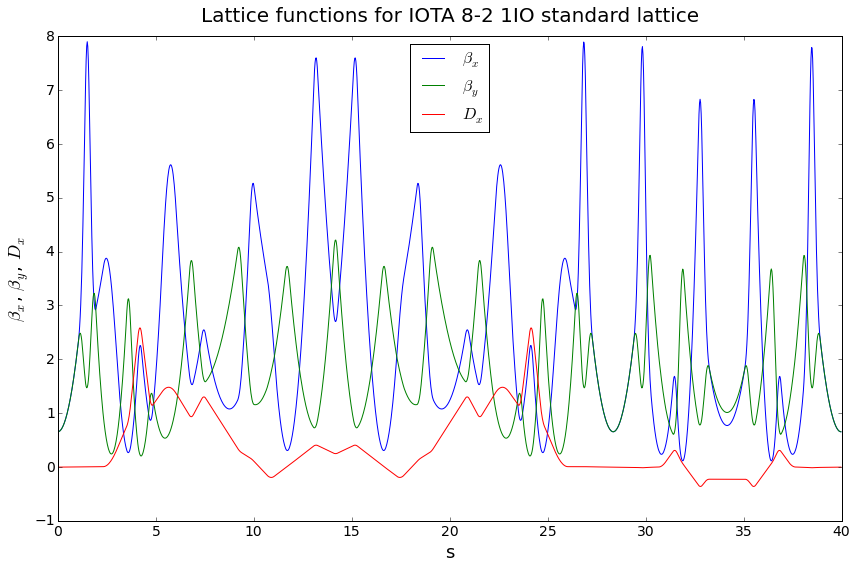

In [10]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO standard lattice'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

## Turn End Action


First we need to identify the elements which will be at the proper place in the lattice (beginning and end of the drift section) and grab the appropriate slices from the lattice simulator in order to get the lattice functions directly.

As it turns out, the lattice simulator only constructs slices for drifts, quads, etc. Markers, apertures, and other elements do not count.

In [143]:
elements = opts.lattice.get_elements()
for ind, ele in enumerate(elements):
    if ele.get_name() == 'nlr2':
        #walk backwards
        new_ind = ind-1
        prev = elements[new_ind]
        while not prev.get_type() == 'drift':
            new_ind = new_ind - 1
            prev = elements[new_ind]
        print "Drift element prior to nlr2 is named {}".format(prev.get_name())
    if ele.get_name() == 'nlr1':
        #walk backwards
        new_ind = ind-1
        prev = elements[new_ind]
        while not prev.get_type() == 'drift':
            new_ind = new_ind - 1
            prev = elements[new_ind]
        print "Drift element prior to nlr1 is named {}".format(prev.get_name())

Drift element prior to nlr2 is named auto_drift_iota_008
Drift element prior to nlr1 is named auto_drift_iota_132


In [276]:
list(enumerate(indices[:,0]))

[(0, 16), (1, 703)]

In [278]:
indices[0,1]

0

In [305]:
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, indices, ptcls):
        '''Indices is a list of arrays of the form [nStep,nOperator,nSlice]'''
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self)
        self.vals = indices
        self.ptcls = ptcls
        #self.nStep = nStep
        #self.nOperator = nOperator
        #self.nSlice = nSlice
        #self.matrix = mat #R-matrix being imported
    
    def step_end_action(self, stepper, step, bunch, turn_num, step_num):
        '''Action to perform at the end of each step'''

        #loop through step numbers
        for ind, s_num in enumerate(self.vals[:,0]):
            #now check the step num and go from there - need an additional +1 because of indexing vs. number
            if step_num == s_num+1:
                #grab the correct operator
                ind_op = self.vals[ind,1]
                ind_slc = self.vals[ind,2]
                
                op = step.get_operators()[ind_op]
                slc = op.get_slices()[ind_slc]
                name = slc.get_lattice_element().get_name()
                
                #grab lattice functions
                lf = ls.get_lattice_functions(slc)
                s = lf.arc_length
                #print "Step {}, Operator {}, Slice {}: Element: {} has s value: {}".format(step_num,ind_op,ind_slc,name,s)
                #print "Lattice functions: betax - {} betay - {}".format(lf.beta_x, lf.beta_y)
                #print "Lattice functions: alphax - {} alpha y - {}".format(lf.alpha_x, lf.alpha_y)

                ptls = bunch.get_local_particles()
                x_pt = ptls[]
                
                self.ptcls.append() 
                    
                
                
def get_names(markers):
    names = []
    elements = opts.lattice.get_elements()
    for ind, ele in enumerate(elements):
        if ele.get_name() in markers:
            #walk backwards
            new_ind = ind-1
            prev = elements[new_ind]
            while not prev.get_type() == 'drift':
                new_ind = new_ind - 1
                prev = elements[new_ind]
            #print "Drift element prior to {} is named {}".format(ele.get_name(),prev.get_name())
            names.append(prev.get_name())
            
    return names

#Now find the correct slices
def find_slices(stepper, lattice_simulator, names, pos):
    '''Return the step number, operator number, and slice number for the correct slices '''
    
    vals = []
    for indS,steps in enumerate(stepper.get_steps()):
        for indO,ops in enumerate(steps.get_operators()):
            if not ops.get_name() == 'stub':
                for indSL, slc in enumerate(ops.get_slices()):
                    name = slc.get_lattice_element().get_name()
                    if name == 'auto_drift_iota_008' or name == 'auto_drift_iota_132':
                        lf = lattice_simulator.get_lattice_functions(slc)
                        s = np.round(lf.arc_length,2)
                        lat_length = np.round(lattice_simulator.get_lattice().get_length(),2)
                        if s-pos == 0 or s == lat_length - pos:
                                vals.append([indS,indO,indSL])
    
    return np.asarray(vals)

pos = 0.9
markers = ['nlr1','nlr2'] #the markers signifying the end of the nonlinear element
names = get_names(markers)
indices = find_slices(opts.stepper,opts.lattice_simulator,names,pos)
step_action = turn_actions(indices)

In [316]:
for num in range(10):
    fn = 'test.txt'
    with open(fn, 'w+') as f:
        f.write('Test text')
        f.write('\n')

In [ ]:
        if name == 'auto_drift_iota_008' or name == 'auto_drift_iota_132':
            #we have the correct slices and we should get the appropriate values
        
            #grab lattice functions
            lf = ls.get_lattice_functions(last_slice)
            s = lf.arc_length
    
            length = 0.9      
            if s == length or s == ls.get_lattice().get_length() - length:  
        
                print "Step: {} - Element: {} has s value: {}".format(step_num,name,s)
                print "Lattice functions: betax - {} betay - {}".format(lf.beta_x, lf.beta_y)
                print "Lattice functions: alphax - {} alpha y - {}".format(lf.alpha_x, lf.alpha_y)

In [271]:
print indices

[[ 16   0   0]
 [703   2   0]]


In [248]:
vals = []
pos = 0.9
for indS,steps in enumerate(stepper.get_steps()):
    for indO,ops in enumerate(steps.get_operators()):
        if not ops.get_name() == 'stub':
            for indSL, slc in enumerate(ops.get_slices()):
                name = slc.get_lattice_element().get_name()
                if name == 'auto_drift_iota_008' or name == 'auto_drift_iota_132':
                    lf = ls.get_lattice_functions(slc)
                    s = np.round(lf.arc_length,2)
                    lat_length = np.round(ls.get_lattice().get_length(),2)
                    #print lat_length
                    if s-pos == 0 or s == lat_length - pos:
                        vals.append([indS,indO,indSL])

In [289]:
stepper = opts.stepper

In [291]:
for indS,steps in enumerate(stepper.get_steps()):
    for indO,ops in enumerate(steps.get_operators()):
            if not ops.get_name() == 'stub':
                for indSL, slc in enumerate(ops.get_slices()):
                    name = slc.get_lattice_element().get_name()
                    if name == 'auto_drift_iota_008' or name == 'auto_drift_iota_132':
                        lf = ls.get_lattice_functions(slc)
                        s = lf.arc_length
                        print "Step {}, Operator {}, Slice {}: Element: {} has s value: {}".format(indS,indO,indSL,name,s)

Step 14, Operator 0, Slice 3: Element: auto_drift_iota_008 has s value: 0.804915737332
Step 14, Operator 2, Slice 0: Element: auto_drift_iota_008 has s value: 0.832671452413
Step 15, Operator 0, Slice 0: Element: auto_drift_iota_008 has s value: 0.860427167493
Step 15, Operator 2, Slice 0: Element: auto_drift_iota_008 has s value: 0.888182882573
Step 16, Operator 0, Slice 0: Element: auto_drift_iota_008 has s value: 0.9
Step 702, Operator 2, Slice 2: Element: auto_drift_iota_132 has s value: 39.0245354031
Step 703, Operator 0, Slice 0: Element: auto_drift_iota_132 has s value: 39.0522911181
Step 703, Operator 2, Slice 0: Element: auto_drift_iota_132 has s value: 39.0682297158


So I DO want the LAST slice from each one (last slice from auto drift 8 and last slice from auto drift 132)

In [155]:
opts.lattice.get_length()

39.96822971580011

In [102]:
op3.get_slices()[-1]

In [104]:
cslice.get_lattice_element().get_name()

'auto_drift_iota_000'

In [49]:
step0 = stepper.get_steps()[0]
op1 = step0.get_operators()[0]
op2 = step0.get_operators()[1]
op3 = step0.get_operators()[2]

In [78]:
step1 = stepper.get_steps()[1]

In [82]:
cslice = step1.get_operators()[2].get_slices()[0]

In [51]:
step0.get_operators()

(<synergia.simulation.simulation.Independent_operator at 0x110e95c08>,
 <synergia.simulation.simulation.Independent_operator at 0x110e781b8>)

In [64]:
for slices in op1.get_slices():
    print "op1 slice: {} to {}".format(slices.get_left(),slices.get_right())
    
#for slices in op2.get_slices():
#    print "op2 slice: {} to {}".format(slices.get_left(),slices.get_right())
    
for slices in op3.get_slices():
    print "op3 slice: {} to {}".format(slices.get_left(),slices.get_right())

op1 slice: 0.0 to 0.0
op1 slice: 0.0 to 0.0
op1 slice: 0.0 to 0.0277557150804
op3 slice: 0.0277557150804 to 0.0555114301608


## Construct the beam and propagate it

In [297]:
opts.lattice = lattice_dict['t1_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82']['lattice_simulator']
opts.stepper = lattice_dict['t1_1IO_82']['stepper']

In [158]:
def dQ_SC_Gauss(N,emit,ref):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ

def dQ_SC_Gauss_2(N,emit,bet,gam):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


def dQ_SC_KV(N,emit,ref):
    '''Return dQsc for a KV beam if given normalized emittance (2x that of Gaussian)'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(2*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


g_emit = 20.e-6 #TOTAL geometric emittance according to Sasha
n_emit = basic_calcs.calc_normalized_emittance(g_emit,opts.beta,opts.gamma)

current = 4.25*1.e-3 #mA of current 
l_IOTA = 39.968229715800064 #length of lattice
#n_emit = 3.e-7 #normalized emittance for IOTA ring for this current
rp_perlength = current/(reference_particle.get_beta()*scipy.constants.c*scipy.constants.e)
n_particles = rp_perlength*l_IOTA

dQ = dQ_SC_Gauss(n_particles,n_emit,reference_particle) #calc dQsc_x
dQ_KV = dQ_SC_KV(n_particles,n_emit,reference_particle) #calc dQsc_x

print "Assume a normalized total emittance of {} mm-mrad.".format(n_emit*1.e6)
print "At {} mA current, # of protons filling ring is {:e} or {:e} p+/cm.".format(current*1.e3,n_particles,n_particles/(100.*l_IOTA))
print "Corresponding space charge tune shift in x is {} for KV distribution".format(dQ_KV)

Assume a normalized total emittance of 1.46096398318 mm-mrad.
At 4.25 mA current, # of protons filling ring is 4.854214e+10 or 1.214518e+07 p+/cm.
Corresponding space charge tune shift in x is -0.111187273361 for KV distribution


#### A few notes on distributions for clarity

Note, for the kV-like distribution in coordinate space, the RMS value in x/y is 1/2 the maximum value. That is, in coordinate space, $\sigma_w = 0.5 w_{max}$. For the Gaussian distribution in momentum space, the RMS value is simply the standard deviation ($\sigma_w = \sigma_{p_w}$). The RMS emittance of the bunch (geometric) is then the product of these two values $\epsilon_w = \sigma_w \times \sigma_{p_w}$. 

Thus, we have $\epsilon_w = 0.5 w_{max} \sigma_{p_w}$. So if we specify a maximum coordinate (e.g. $x_{max}$), then we can define $\sigma_{p_w} = 2 \epsilon_w / w_{max}$

For a beam not at a waist, the beam should have a coordinate rotation applied by the twiss parameter matrix in each plane, but since we are injecting at beam waists we don't have to worry about this.

*Defining $x_{max}$*. This follows from the convention of defining $\epsilon_{x} = \sigma_x^2/\beta_x$. For a KV-like distribution in coordinate space, we can relate the maximum x value to the RMS via $\sigma_x = \sqrt{2}/2 x_{max}$. Thus, we have $x_{max} = \sqrt{2 \beta_x \epsilon_x}$.


In [261]:
new_vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])

Initial starting lattice functions: betax = 0.627584359882, betay = 0.579814046894, alphax = -0.0343278189644, alphay = 0.0232141439896


In [306]:
n_ppc = 10

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
opts.macro_particles = n_macro

#======================= Now setup the bunch and other related options =====================
opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
#opts.betae = vals[3]
#opts.alphae = 0 #fixed 0 alpha for center
#opts.beta0 = vals[3]

#Get immediate beta value from lattice simulator and match to this instead
new_vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])
opts.betae = new_vals[0]
opts.alphae = 0
opts.beta0 = new_vals[0]


#opts.dpop = 0.4/100 #0.4% dpop
dpop = 0.0
opts.dpop = dpop #0.1% dpop

current = 4.25e-3 #mA of current 
rp_perlength = current/(opts.beta*constants.c*constants.e)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length
opts.real_particles = rp_perlength*bunch_length

#opts.emit = 9.47.e-7
#opts.emit = n_emit = 8.1e-7 #
opts.emit = 0.5*g_emit# USE THE GEOMETRIC EMITTANCE!!!!
opts.emits = [opts.emit]

if myrank == 0:
    #construct a bunch and make sure to add longitudinal momentum variation
    #particles = SemiGaussian6D.semiGaussianBeam6D(opts)
    particles = StandardBeam6D.toyKVBeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        #initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        #bunch_mean = np.mean(initialH)
        #bunch_std = np.std(initialH)
        #bunch_var = (bunch_std/bunch_mean)*100
        #print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        #bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))
        bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

    np.savetxt('my_KV_bunch_82.txt',bunch)         #write the bunch to a text file


bucket_length = bunch_length
particles_file = 'my_KV_bunch_82.txt'
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Initial starting lattice functions: betax = 0.627584359882, betay = 0.579814046894, alphax = -0.0343278189644, alphay = 0.0232141439896
Loading Synergia particles from txt file:  my_KV_bunch_82.txt
Read  10240  particles


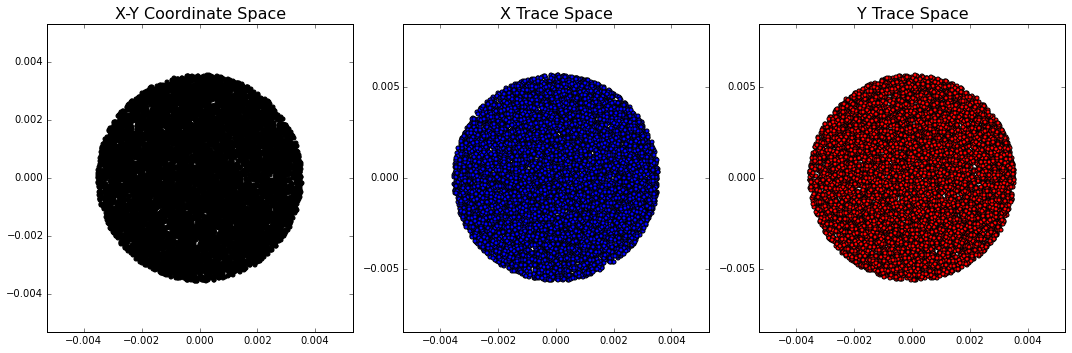

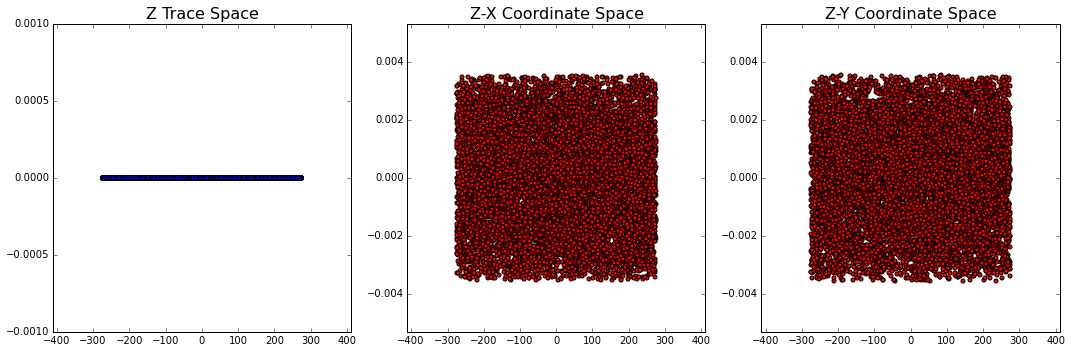

In [107]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [13]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.76283745921 mm
rms envelope y: 1.77591176227 mm
maximum x value is : 3.53243342232 mm
maximum y value is : 3.52823618353 mm
rms beta x: 0.621090114761
rms beta y: 0.631253497596
geometric emittance x: 5.00345414255 mm-mrad
geometric emittance y: 4.99619027759 mm-mrad
normalized emittance x: 0.365493314689 mm-mrad
normalized emittance y: 0.364962702434 mm-mrad
mean of xp^2 : 8.05592300319e-06
mean of yp^2 : 7.91471302197e-06
total geometric emittance x: 20.0906206467 mm-mrad
total geometric emittance y: 19.7202084649 mm-mrad


In [307]:
outputdir = 'ZC-Step-End-Check'

opts.output_dir = outputdir
workflow.make_path(outputdir)

bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [308]:
opts.turns = 1
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
#propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)
propagator.propagate(bunch_simulator,step_action,opts.turns, opts.maxturns,opts.verbosity) #turn_action

workflow.cleanup(opts.output_dir)

Step 17, Operator 0, Slice 0: Element: auto_drift_iota_008 has s value: 0.9
Lattice functions: betax - 1.89262120314 betay - 1.89263344302
Lattice functions: alphax - -1.37637711934 alpha y - -1.37637209703
Step 704, Operator 2, Slice 0: Element: auto_drift_iota_132 has s value: 39.0682297158
Lattice functions: betax - 1.89264413819 betay - 1.89261874665
Lattice functions: alphax - 1.37638986103 alpha y - 1.37636393238


## Analysis

### Analysis - Beam Envelopes

In [140]:
for ele in elements:
    print "{} : {}".format(ele.get_name(),ele.get_type())

ior : marker
mn01 : marker
auto_drift_iota_000 : drift
mn01 : marker
mn02 : marker
auto_drift_iota_001 : drift
mn02 : marker
mn03 : marker
auto_drift_iota_002 : drift
mn03 : marker
mn04 : marker
auto_drift_iota_003 : drift
mn04 : marker
mn05 : marker
auto_drift_iota_004 : drift
mn05 : marker
mn06 : marker
auto_drift_iota_005 : drift
mn06 : marker
mn07 : marker
auto_drift_iota_006 : drift
mn07 : marker
mn08 : marker
auto_drift_iota_007 : drift
mn08 : marker
mn09 : marker
auto_drift_iota_008 : drift
mn09 : marker
nlr2 : marker
auto_drift_iota_009 : drift
ibpm : monitor
auto_drift_iota_010 : drift
qb4r : quadrupole
auto_drift_iota_011 : drift
qb5r : quadrupole
auto_drift_iota_012 : drift
qb6r : quadrupole
auto_drift_iota_013 : drift
sqb2r : quadrupole
auto_drift_iota_014 : drift
dedge : dipedge
m2r : sbend
dedge : dipedge
auto_drift_iota_015 : drift
sqc1r : quadrupole
auto_drift_iota_016 : drift
ibpm : monitor
auto_drift_iota_017 : drift
qc1r : quadrupole
auto_drift_iota_018 : drift
sc1r 

In [135]:
opts.lattice.get_elements()[27].get_name()

'mn09'

In [16]:
from base_diagnostics import diagplot2

opts.relpath = opts.output_dir

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot2.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#we want to plot turn 0 and turn 100 on the same plot, so we should separate these specifically
interval = opts.steps 
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_end = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_end = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

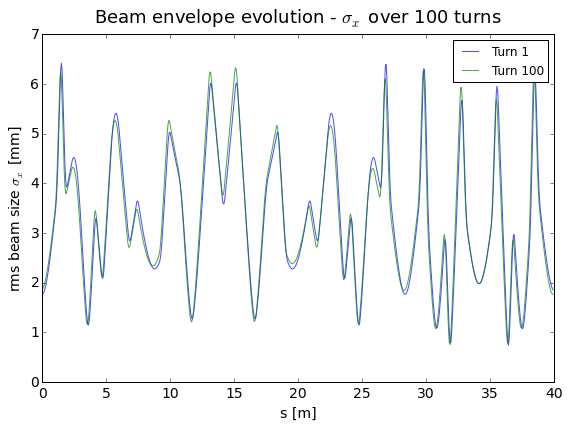

In [17]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_end*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over 100 turns"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_x_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

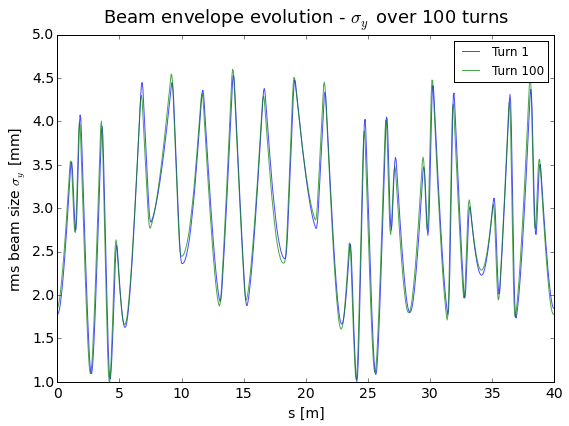

In [18]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,ystd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_y$ over 100 turns"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_y_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

### Analysis - Bunch Properties

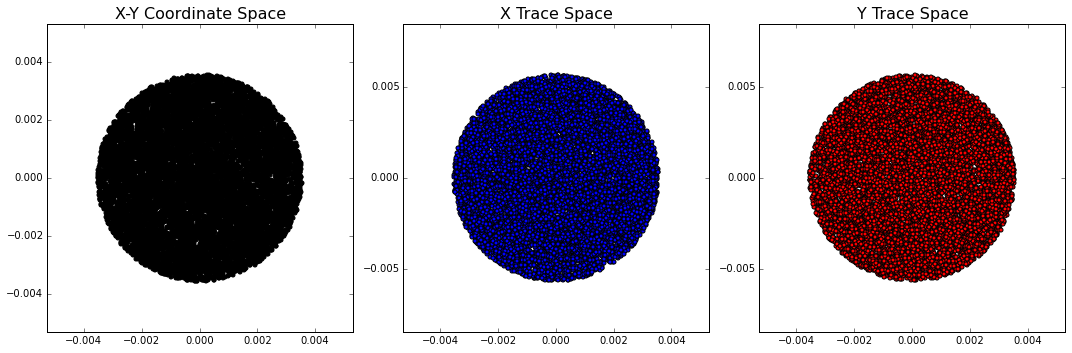

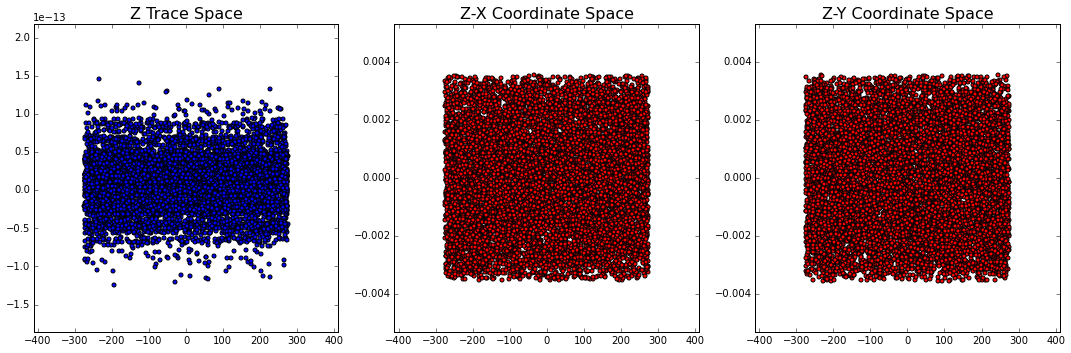

In [19]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [20]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.76287713435 mm
rms envelope y: 1.77591599477 mm
maximum x value is : 3.53284702739 mm
maximum y value is : 3.52824853981 mm
rms beta x: 0.621116706219
rms beta y: 0.631256404173
geometric emittance x: 5.00346514544 mm-mrad
geometric emittance y: 4.99619108755 mm-mrad
normalized emittance x: 0.36549411843 mm-mrad
normalized emittance y: 0.3649627616 mm-mrad
mean of xp^2 : 8.05559582497e-06
mean of yp^2 : 7.91467786231e-06
total geometric emittance x: 20.0944653299 mm-mrad
total geometric emittance y: 19.7202557889 mm-mrad


In [21]:
files = elliptic_sp.get_file_list(opts)
twiss = twiss = elliptic_sp.get_toy_twiss(opts)

rms_table = []

for inputfile in files:
    fn = inputfile[-7:-3]
    
    parts = elliptic_sp.get_particles(inputfile)[1]
    header= {}
    header['s_val'] = 0.
    #norm_coords = elliptic_sp.normalized_coordinates(header, part_array, twiss)
    
    x_rms = basic_calcs.get_rms_envelope('x',parts)
    y_rms = basic_calcs.get_rms_envelope('y',parts)
    
    rms_table.append((int(fn),x_rms,y_rms))
    
    #print "File {} : xrms = {:.2f} mm and yrms = {:.2f} mm".format(fn, x_rms*1.e3, y_rms*1.e3)
    
rms_array = np.asarray(rms_table)

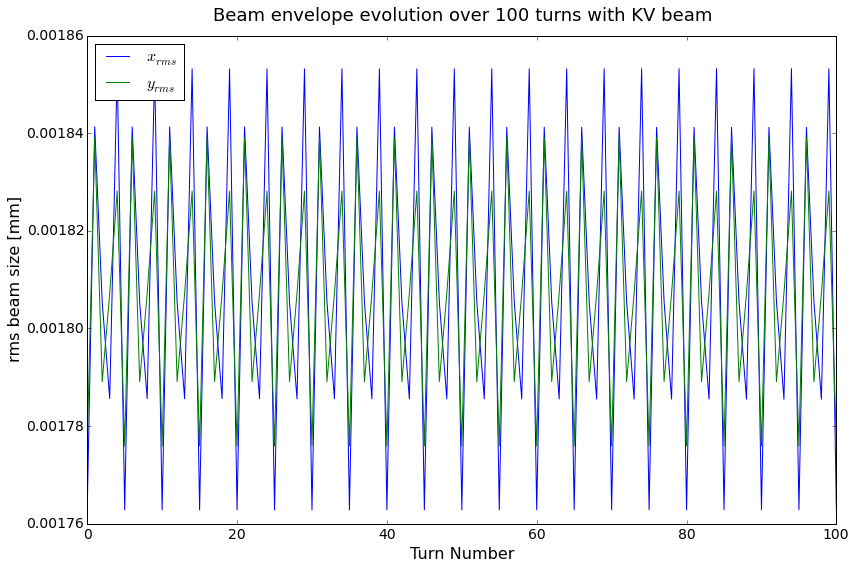

In [24]:
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (12,8))
plt.subplot(1,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1], label = '$x_{rms}$')
ax.plot(rms_array[:,0],rms_array[:,2], label = '$y_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=16)
ax.set_ylabel("rms beam size [mm]",fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend(loc=2,prop={'size':16})
sv_title = 'Benchmark_KV_{}turns_Zero_Current.pdf'.format(num_turns)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')


plt.show()

### Analysis - Tune depression

In [25]:
def get_particle_coords(ID, num, opts):
    '''Return particle (human) coordinates for particle with ID over first num turns'''
    
    files = elliptic_sp.get_file_list(opts)
    twiss = elliptic_sp.get_toy_twiss(opts)

    part_array = []

    for index,outfile in enumerate(files[:num]):
        
        #if index%20 == 0:
            #print "Grabbing particle {} coordinates for file {}".format(ID,index)
    
        particle = elliptic_sp.get_one_particle(outfile,ID)
    
        if index ==0:
            part_array = particle
        else:
            part_array = np.vstack([part_array,particle])
            
    return part_array

def estimate_tune(x_c, t_s = 1):
    '''Estimate the tune using an FFT of particle coordinates'''
    
    num_used = len(x_c[t_s:])
    tv = np.arange(num_used)*1.0/num_used
    sp = np.fft.fft(x_c[t_s:])
    #plt.plot(tv,sp.real)


    smax = np.max(sp.real)
    m_ind = np.where(sp.real == smax)
    Q_guess =m_ind[0][0]*1./num_used
    if Q_guess > 0.5:
        Q_calc = 1.- Q_guess
    else:
        Q_calc = Q_guess
    #print "Maximum is at {}".format(Q_calc)
    return Q_calc

def estimate_tune_unwrap(x_c,px_c,t_s):
    '''Estimate the tune using a phase unwrap algorithm
    
    Inputs:
        -x_c = normalized spatial coordinate
        -px_c = normalized momentum cooridnate
        -t_s = starting turn value from the array of coordinates
    
    '''
    ang_norm = []
    for x,y in zip(x_c,px_c):
        if x > 0 and y > 0: #quandrant I
            ang_norm.append(np.arctan(y/x))
        elif x < 0 and y > 0: #quandrant II
            ang_norm.append(0.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))
        elif x < 0 and y < 0: #quadrant III
            ang_norm.append(np.pi + np.abs(np.arctan(y/x)))
        else: #quadrant IV
            ang_norm.append(1.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))

    #take diference between elements
    diff_ang = np.ediff1d(ang_norm)

    #adjust for wrapping by replacing positive values with 2pi-val
    dff_adjust = []
    for val in diff_ang:
        if val > 0:
            val = val - 2*np.pi
        dff_adjust.append(val)

    #now look at the last 50-80 turns
    #np.mean(dff_adjust[30:])
    t_s = 0
    meantune = -1*(np.mean(dff_adjust[t_s:]))/(2*np.pi)
    #print "{} is the mean tune for particle 0 after turn {}".format(meantune,t_s)
    return meantune

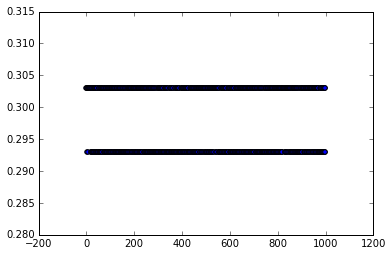

In [26]:
num_t = 100
IDlist = np.arange(1000)
tune_array = []

twiss = twiss = elliptic_sp.get_toy_twiss(opts)
header= {}
header['s_val'] = 0.

#px_c = norm_coords[:,1]
#py_c = norm_coords[:,3]
#plt.scatter(x_c, px_c)

for ID in IDlist:
    p_A = get_particle_coords(ID,num_t,opts)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    x_c = norm_coords[:,0]
    y_c = norm_coords[:,2]
    px_c = norm_coords[:,1]
    py_c = norm_coords[:,3]    
    Qx = estimate_tune(x_c)
    Qx_2 = estimate_tune_unwrap(x_c,px_c,0)
    Qy = estimate_tune(y_c)
    Qy_2 = estimate_tune_unwrap(x_c,px_c,0)
    tune_array.append((ID,Qx,Qy,Qx_2,Qy_2))
    #print "Tune guess for particle {}: {}".format(ID,tune_guess)

tune_array = np.asarray(tune_array)
plt.scatter(tune_array[:,0],tune_array[:,1])

The tune spread is easier to observe using a histogram/distribution plot. Note that because we only examined 250 turns, our sampling is rather low, and as a result our resolution for something like a histogram is pretty bad.

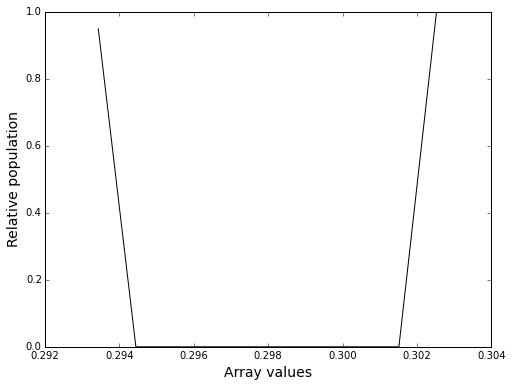

In [31]:
utils.plot_distribution(tune_array[:,1],10)

We can similarly examine a single particle's trajectory in its normal form.

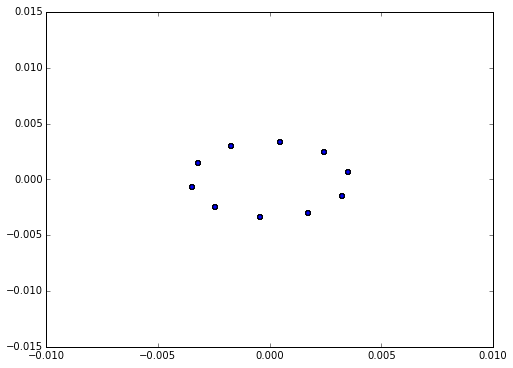

In [32]:
p_A = get_particle_coords(12,num_t,opts)
norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
x_c = norm_coords[:,0]
y_c = norm_coords[:,2]
px_c = norm_coords[:,1]
py_c = norm_coords[:,3]    
Qx = estimate_tune(x_c)
Qy = estimate_tune(y_c)

plt.scatter(x_c, px_c)